# Create ET and EEG datasets from .xdf files


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import itertools
import numpy as np
import os
import pyxdf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mne
import json
import glob
import re
from scipy import signal
import importlib
import multiprocessing as mp
import sys
from utils.eeg_preprocess import *

#from mne.preprocessing import ASR


In [2]:
"""
Get the EEG data from xdf file. 
The xdf contains both the EEG and the eye tracking data.
Read xdf and extract just the EEG
"""
DATA_PATH = './raw_data/'
PROCESSED_PATH = './processed_data/'

montagefile = "./ANT_EEG_channel_mapping.json"

os.makedirs(PROCESSED_PATH,  exist_ok=True)

In [4]:
"""
Get the EEG data from xdf file. 
The xdf contains both the EEG and the eye tracking data.
Read xdf and extract just the EEG
"""
DATA = './raw_data/M006'
DATA_FILE = "M006_1.xdf"

# Read Data from xdf
data, header = pyxdf.load_xdf(os.path.join(DATA,DATA_FILE))

[
    print(
        f"Stream ID:{idx} \n", 
        f"Stream Name: {stream['info']['name']}\n", 
        f"Stream Fields: {stream['info']['desc'][0].keys()}\n",
        f"Stream Time: {stream['time_stamps'].shape}\n",
#         f"Stream First Time: {stream['time_stamps'][0]}\n\n"
    ) 
    for idx, stream in enumerate(data) if stream['time_stamps'].shape !=0
    
]

Stream ID:0 
 Stream Name: ['TrialStopMeasurementTimeStamp']
 Stream Fields: dict_keys(['TrialStopMeasurementTimeStamp'])
 Stream Time: (0,)

Stream ID:1 
 Stream Name: ['CueTimeStamp']
 Stream Fields: dict_keys(['CueTimeStamp'])
 Stream Time: (48,)

Stream ID:2 
 Stream Name: ['TrialStartMeasurementTimeStamp']
 Stream Fields: dict_keys(['TrialStartMeasurementTimeStamp'])
 Stream Time: (48,)

Stream ID:3 
 Stream Name: ['CueDisappearedTimeStamp']
 Stream Fields: dict_keys(['CueDisappearedTimeStamp'])
 Stream Time: (48,)

Stream ID:4 
 Stream Name: ['ValidationResults']
 Stream Fields: dict_keys(['xError', 'yError', 'zError'])
 Stream Time: (6,)

Stream ID:5 
 Stream Name: ['openvibeMarkers']
 Stream Fields: dict_keys(['channels'])
 Stream Time: (0,)

Stream ID:6 
 Stream Name: ['openvibeSignal']
 Stream Fields: dict_keys(['channels'])
 Stream Time: (1263072,)

Stream ID:7 
 Stream Name: ['ButtonPressedTimeStamp']
 Stream Fields: dict_keys(['ButtonPressedTimeStamp'])
 Stream Time: (48,)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [5]:
data[13]['time_stamps'] - data[14]['time_stamps']

array([-5.00849757])

In [8]:
print(data[7]['time_stamps'].shape, data[5]['time_stamps'])


(48,) []


## Read config file

In [4]:

with open('./discarded_data/P002\\gti_config_1652438777.83905.json', 'r') as f:
    config_json = json.loads(f.read())

dict_tools = {}
dict_tools['tools'] = config_json['MappedTool']
dict_tools['extends'] = config_json['ToolColliderExtends']

tool_info = pd.DataFrame.from_dict(dict_tools)
tool_info[['tool_pos_x','tool_pos_y', 'tool_pos_z']] = tool_info['extends'].apply(pd.Series)
tool_info.drop(columns=['extends'], inplace=True)
tool_info.rename(columns = {'tools':'tool_name'}, inplace=True)
tool_info['tool_name'] = tool_info.tool_name.str.lower()
tool_info

,tool_name,tool_pos_x,tool_pos_y,tool_pos_z
0,practicehammer,0.208975,0.049109,0.398685
1,flowercutter,0.051337,0.034490,0.465000
2,fishscaler,0.111392,0.027690,0.500855
3,paintbrush,0.083830,0.023186,0.319111
4,paletteknife,0.082688,0.041789,0.460310
5,screwdriver,0.075933,0.075910,0.500602
6,trowel,0.133451,0.060288,0.593202
7,daisygrubber,0.102008,0.093502,0.638365
8,wrench,0.095500,0.026071,0.394331
9,zester,0.061505,0.045747,0.393622


In [5]:
TRIGGERS = [
    'BaseLineBeginTimeStamp',
    'BaseLineEndTimeStamp',
    'CueTimeStamp',
    'CueDisappearedTimeStamp',
    'ObjectShownTimeStamp',
    'BeepPlayedTimeStamp',
    'ButtonPressedTimeStamp'
]

TRIAL_INFO = 'TrialInformationInt'

EEG_SIGNAL = 'openvibeSignal'

ET_SIGNAL = 'EyeTrackingGazeHMDFloat'

STIMULUS = ['ToolCueOrientationString', 'ToolCueOrientationInt']

TOOLS = ['daisygrubber', 'fishscaler', 'flowercutter', 'fork', 'paintbrush',
       'paletteknife', 'screwdriver', 'spatula', 'spokewrench', 'trowel',
       'wrench', 'zester']

FAMILIAR = ['fork','trowel','screwdriver','spatula','paintbrush','wrench']

tool_fam_map = {t:('fam' if t in FAMILIAR else 'unfam') for t in TOOLS}

EVENT_MAPPING = {'task': 1,
                 'inter-task-object': 2,
                 'object': 3,
                 'action': 4,
                 'inter-trial':5 }

In [40]:
def get_streams(data):
    streams = {} 
    
    if len(data) == 0:
        print('No data in stream')
        return 0
    for i in range(len(data)):
        if data[i]["info"]['name'][0] == EEG_SIGNAL:
            streams['eeg'] = int(i)
            
        elif data[i]["info"]['name'][0] == ET_SIGNAL:
            streams['et'] = int(i)
            
        elif data[i]["info"]['name'][0] in TRIAL_INFO:
            streams[data[i]["info"]['name'][0]] = int(i)
            
        elif data[i]["info"]['name'][0] in TRIGGERS:
            streams[data[i]["info"]['name'][0]] = int(i)
            
        else:
            continue

    return streams

## Create ET DATA

In [7]:
from utils.read_data import *
from functools import partial

# Read Data from xdf
stream_df = pd.DataFrame()
et_samples_df = pd.DataFrame()


TASK_DICT = {0:'use', 1:'lift'}
ORI_DICT = {0:'right', 1:'left'}
FAM_DICT = {
    'daisygrubber':'unfam', 'fishscaler':'unfam', 'flowercutter':'unfam', 
    'zester':'unfam', 'spokewrench':'unfam', 'paletteknife':'unfam',
    'fork':'fam', 'paintbrush':'fam', 'screwdriver':'fam', 
    'spatula':'fam', 'trowel':'fam', 'wrench':'fam', 
}

with mp.Pool(mp.cpu_count() - 1) as p:
    retlist = p.map(
                partial(
                    read_et_df,
                    tool_dict=tool_info, 
                    fam_dict=FAM_DICT, 
                    task_dict=TASK_DICT, 
                    ori_dict=ORI_DICT,
                ),
                glob.glob(os.path.join("./raw_data/M0*","*.xdf"))
            )
    
#     print(retlist)
    
tmp = [data for data in retlist if len(data)!=0]
et_samples_df = pd.concat(tmp, ignore_index=True)

display(stream_df)
display(et_samples_df)

et_samples_df.to_csv(f'{PROCESSED_PATH}/00_ET_samples.csv')

""


,hmdPos.x,hmdPos.y,hmdPos.z,hmdRotation.x,hmdRotation.y,hmdRotation.z,hmdDirectionForward.x,hmdDirectionForward.y,hmdDirectionForward.z,controllerPosition.x,...,beep_time,object_time,tool_name,tool_pos_x,tool_pos_y,tool_pos_z,task,orientation,time,familiarity
0,-0.007580,1.202312,0.359243,14.818667,2.403177,4.030236,0.040536,-0.255761,0.965890,0.150678,...,1.073066e+06,1.073063e+06,fishscaler,0.111392,0.027690,0.500855,use,right,-4.111459,unfam
1,-0.007583,1.202413,0.359154,14.786912,2.401190,4.036905,0.040509,-0.255225,0.966033,0.150660,...,1.073066e+06,1.073063e+06,fishscaler,0.111392,0.027690,0.500855,use,right,-4.100460,unfam
2,-0.007579,1.202523,0.359064,14.751578,2.403390,4.039632,0.040553,-0.254629,0.966188,0.150567,...,1.073066e+06,1.073063e+06,fishscaler,0.111392,0.027690,0.500855,use,right,-4.089452,unfam
3,-0.007548,1.202593,0.358988,14.725022,2.407199,4.034133,0.040622,-0.254180,0.966303,0.150341,...,1.073066e+06,1.073063e+06,fishscaler,0.111392,0.027690,0.500855,use,right,-4.077455,unfam
4,-0.007534,1.202675,0.358884,14.697697,2.410301,4.048664,0.040679,-0.253719,0.966422,0.150136,...,1.073066e+06,1.073063e+06,fishscaler,0.111392,0.027690,0.500855,use,right,-4.066448,unfam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5164083,0.002688,1.243030,0.135560,18.445049,359.643402,359.219452,-0.005904,-0.316395,0.948609,-0.086771,...,5.245398e+05,5.245368e+05,paintbrush,0.083830,0.023186,0.319111,lift,left,3.964006,fam
5164084,0.002248,1.243049,0.135887,18.478350,359.697937,359.214203,-0.005000,-0.316946,0.948430,-0.088927,...,5.245398e+05,5.245368e+05,paintbrush,0.083830,0.023186,0.319111,lift,left,3.975000,fam
5164085,0.001811,1.243068,0.136203,18.502861,359.754364,359.202423,-0.004066,-0.317352,0.948299,-0.090674,...,5.245398e+05,5.245368e+05,paintbrush,0.083830,0.023186,0.319111,lift,left,3.986004,fam
5164086,0.001369,1.243153,0.136455,18.499409,359.787018,359.191650,-0.003525,-0.317295,0.948320,-0.091952,...,5.245398e+05,5.245368e+05,paintbrush,0.083830,0.023186,0.319111,lift,left,3.997000,fam


In [62]:
del et_samples_df

In [63]:
et_samples_df = pd.read_csv(f'{PROCESSED_PATH}/00_ET_samples.csv')

In [75]:
trial_info = (
    et_samples_df
    .groupby(['subject_id', 'block_id', 'trial_id', 'familiarity', 'task', 'orientation', 'tool_name'])
    .time
    .count()
    .reset_index()
)
trial_info['condition'] = (
    trial_info.familiarity 
    + '/' + trial_info.task 
    + '/' + trial_info.orientation
)
display(trial_info.head())

trial_info.to_csv(f'{PROCESSED_PATH}/trial_conditions.csv')

,subject_id,block_id,trial_id,familiarity,task,orientation,tool_name,time,condition
0,M006,1,1.0,unfam,use,right,fishscaler,732,unfam/use/right
1,M006,1,2.0,fam,use,right,paintbrush,732,fam/use/right
2,M006,1,3.0,fam,use,right,fork,732,fam/use/right
3,M006,1,4.0,fam,lift,right,spatula,732,fam/lift/right
4,M006,1,5.0,unfam,use,left,fishscaler,732,unfam/use/left


In [67]:
(
    et_samples_df
    .groupby(['subject_id', 'block_id'], as_index=False)
    .trial_id
    .nunique()
    .groupby('subject_id')
    .trial_id
    .sum()
)

subject_id
M006    288
Name: trial_id, dtype: int64

### Fixation Detection

In [35]:
from utils.et_preprocess import *

et_samples_df['eye_theta_h'] = np.degrees(
    np.arctan2(et_samples_df['eyeDirectionCombinedWorld.x'], et_samples_df['eyeDirectionCombinedWorld.z'])
)
et_samples_df['eye_theta_v'] = np.degrees(
    np.arctan2(et_samples_df['eyeDirectionCombinedWorld.y'], et_samples_df['eyeDirectionCombinedWorld.z'])
)

et_samples_df.reset_index(inplace=True)
et_samples_df.sort_values(by='timestamps', inplace=True)

et_samples_df['vel_h'] = (
    et_samples_df
    .groupby(['subject_id','block_id', 'trial_id'])
    .eye_theta_h
    .apply(lambda x: x.diff())
    )/(et_samples_df
    .groupby(['subject_id','block_id', 'trial_id'])
    .timestamps
    .apply(lambda x: x.diff())
    )

et_samples_df['vel_v'] = (
    et_samples_df
    .groupby(['subject_id','block_id', 'trial_id'])
    .eye_theta_v
    .apply(lambda x: x.diff())
    )/(et_samples_df
    .groupby(['subject_id','block_id', 'trial_id'])
    .timestamps
    .apply(lambda x: x.diff())
    )

et_samples_df['vel'] = np.sqrt(et_samples_df.vel_h**2 + et_samples_df.vel_v**2)


In [36]:
et_samples_df['filt_vel'] = (
    et_samples_df
    .groupby(['subject_id', 'block_id', 'trial_id'])
    .vel
    .transform(
        lambda x:  signal.medfilt(x, kernel_size=3)
        #x.interpolate(method='linear', axis=0, limit_area='inside')
    )
)

In [37]:
et_samples_df[['filt_vel', 'vel', 'vel_h', 'vel_v', 'eye_theta_h']].isna().mean()

filt_vel       0.000000
vel            0.001366
vel_h          0.001366
vel_v          0.001366
eye_theta_h    0.000000
dtype: float64

In [38]:
# Detect Fixations with AT_MAD method
et_samples_df['is_fixation'] = False
et_samples_df['is_fixation'] = (
    et_samples_df
    .groupby(['subject_id','block_id', 'trial_id'], as_index=False)
    .filt_vel
    .transform(lambda x: x < at_mad(x))
)

D:\projects\GTI_decoding\code\paper\utils\et_preprocess.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  angular_vel = angular_vel[:,None]


In [39]:
# Calculate fixation duration
et_samples_df.set_index('timestamps', inplace=True)
et_samples_df['is_fixation'] = et_samples_df['is_fixation'].astype(int)
et_samples_df['fix_duration'] = (
    et_samples_df
    .groupby(['subject_id', 'block_id', 'trial_id'], as_index=False)
    .is_fixation
    .apply(
        lambda x: x
        .groupby((x != x.shift()).cumsum())
        .transform(lambda x: (x.index[-1] - x.index[0]))
    )
).reset_index().set_index('timestamps').is_fixation

In [40]:
# If Saccade duration is less than 0.03s, make it part of previous fixation
# If fixation duration is less than 50ms, make it part of previous saccade

et_samples_df.loc[
    (
        (et_samples_df.is_fixation == 0) 
        & (et_samples_df.fix_duration<=0.03) 
        & (et_samples_df.fix_duration >= 0)
    ), 'is_fixation'
] = 1

et_samples_df.loc[
    (
        (et_samples_df.is_fixation == 1) 
        & (et_samples_df.fix_duration<=0.05) 
        & (et_samples_df.fix_duration >= 0)
    ), 'is_fixation'
] = 0

In [41]:
##### recalculate fixation duration for new sample labels
et_samples_df['fix_duration'] = (
    et_samples_df
    .groupby(['subject_id', 'block_id', 'trial_id'], as_index=False)
    .is_fixation
    .apply(
        lambda x: x
        .groupby((x != x.shift()).cumsum())
        .transform(lambda x: (x.index[-1] - x.index[0]))
    )
).reset_index().set_index('timestamps').is_fixation

# calculate fixation onset
et_samples_df['fix_onset'] = (
    et_samples_df
    .groupby(['subject_id', 'block_id', 'trial_id'], as_index=False)
    .is_fixation
    .apply(
        lambda x: x
        .groupby((x != x.shift()).cumsum())
        .transform(lambda x: x.index[0])
    )
).reset_index().set_index('timestamps').is_fixation

### Outlier detection

In [42]:
# add column for outlier fixation or saccade durations 
# based on population sample with MAD with threshold 3.5
et_samples_df['isOutlierFix'] = (et_samples_df
                              .query('is_fixation == 1 and fix_duration != 0')
                              .fix_duration
                              .transform(lambda x: x > simple_mad(x, 3.5))
                             )

et_samples_df['isOutlierSac'] = (et_samples_df
                              .query('is_fixation == 0 and fix_duration != 0')
                              .fix_duration
                              .transform(lambda x: x > simple_mad(x, 3.5))
                             )

display(et_samples_df['isOutlierFix'].value_counts(normalize=True))
display(et_samples_df['isOutlierSac'].value_counts(normalize=True))

D:\projects\GTI_decoding\code\paper\utils\et_preprocess.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  angular_vel = angular_vel[:,None]


False    0.872632
True     0.127368
Name: isOutlierFix, dtype: float64

False    0.89539
True     0.10461
Name: isOutlierSac, dtype: float64

### Label order of fixations

In [43]:
et_samples_df['fix_order'] = (
    et_samples_df
#     .query('time>=0 ')
    .groupby(['subject_id', 'block_id', 'trial_id',])
    .is_fixation
    .apply(lambda x: (x!=x.shift()).cumsum())
)

et_samples_df.loc[et_samples_df.is_fixation==0, 'fix_order'] = np.nan
et_samples_df.loc[(et_samples_df.is_fixation==1) & (et_samples_df.isOutlierFix==1), 'fix_order'] = np.nan

In [44]:
select_cols = ['time', 'subject_id', 'block_id', 'trial_id', 'tool_id',
       'cue_time', 'beep_time', 'object_time', 'tool_name', 'task', 'orientation', 
        'familiarity', 'is_fixation', 'fix_duration', 
        'isOutlierFix', 'fix_order', 'fix_onset']

tmpdf = et_samples_df[select_cols]

tmpdf = (
    tmpdf
    .query('is_fixation == 1 and isOutlierFix==False')
    .dropna(subset=['fix_order'])
    .drop_duplicates(subset=[
        'subject_id', 'block_id', 'trial_id', 'tool_id',
        'cue_time', 'beep_time', 'tool_name', 'task', 'orientation', 
        'familiarity', 'is_fixation', 'fix_duration', 
        'isOutlierFix', 'fix_order',
    ])
)

tmpdf['fix_order'] = (
    tmpdf
    .query('time>=0')
    .groupby(['subject_id', 'block_id', 'trial_id',])
    .fix_order
    .cumcount()+1
)

tmpdf

,time,subject_id,block_id,trial_id,tool_id,cue_time,beep_time,object_time,tool_name,task,orientation,familiarity,is_fixation,fix_duration,isOutlierFix,fix_order,fix_onset
timestamps,,,,,,,,,,,,,,,,,
2.322679e+02,-4.110914,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.233017,False,NaN,2.322679e+02
2.327899e+02,-3.588907,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.166996,False,NaN,2.327899e+02
2.331349e+02,-3.243907,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.210001,False,NaN,2.331349e+02
2.335679e+02,-2.810907,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.166001,False,NaN,2.335679e+02
2.337569e+02,-2.621900,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.098990,False,NaN,2.337569e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.947127e+06,2.586130,M026,3,48.0,2.0,1.947120e+06,1.947127e+06,1.947124e+06,fishscaler,use,right,unfam,1,0.077998,False,8.0,1.947127e+06
1.947127e+06,2.742138,M026,3,48.0,2.0,1.947120e+06,1.947127e+06,1.947124e+06,fishscaler,use,right,unfam,1,0.365997,False,9.0,1.947127e+06
1.947127e+06,3.142143,M026,3,48.0,2.0,1.947120e+06,1.947127e+06,1.947124e+06,fishscaler,use,right,unfam,1,0.355995,False,10.0,1.947127e+06


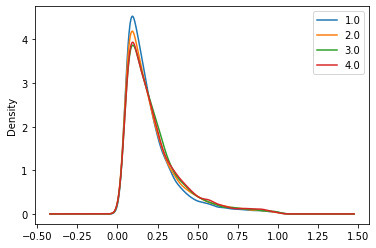

In [45]:
ax = (
    tmpdf
    .query('fix_order<=4')
    .groupby(['fix_order'])
    .fix_duration
    .plot.kde(legend=True)
)

In [46]:
trial_info = (
    tmpdf
    .query('time>=0 and time <=3 and fix_order<=3')
#     .set_index(['subject_id', 'block_id', 'trial_id', 'fix_order'])
)
trial_info.to_csv(f'{PROCESSED_PATH}/trial_event_info.csv')
trial_info

,time,subject_id,block_id,trial_id,tool_id,cue_time,beep_time,object_time,tool_name,task,orientation,familiarity,is_fixation,fix_duration,isOutlierFix,fix_order,fix_onset
timestamps,,,,,,,,,,,,,,,,,
2.367659e+02,0.387105,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.311030,False,1.0,2.367659e+02
2.371769e+02,0.798116,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.266996,False,2.0,2.371769e+02
2.376439e+02,1.265114,M026,4,1.0,7.0,2.323579e+02,2.393879e+02,2.363788e+02,daisygrubber,use,left,unfam,1,0.110996,False,3.0,2.376439e+02
2.555019e+02,0.197890,M026,4,2.0,11.0,2.512938e+02,2.583127e+02,2.553040e+02,spokewrench,use,right,unfam,1,0.110991,False,1.0,2.555019e+02
2.557129e+02,0.408906,M026,4,2.0,11.0,2.512938e+02,2.583127e+02,2.553040e+02,spokewrench,use,right,unfam,1,0.221982,False,2.0,2.557129e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.947110e+06,1.132245,M026,3,47.0,8.0,1.947104e+06,1.947111e+06,1.947108e+06,wrench,use,right,fam,1,0.222006,False,2.0,1.947110e+06
1.947110e+06,1.476249,M026,3,47.0,8.0,1.947104e+06,1.947111e+06,1.947108e+06,wrench,use,right,fam,1,0.166995,False,3.0,1.947110e+06
1.947124e+06,0.110120,M026,3,48.0,2.0,1.947120e+06,1.947127e+06,1.947124e+06,fishscaler,use,right,unfam,1,0.078002,False,1.0,1.947124e+06


C:\Users\akeshava\AppData\Local\Temp/ipykernel_20044/2316638616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_info['object_dur'] = trial_info['beep_time'] - trial_info['object_time']
C:\Users\akeshava\AppData\Local\Temp/ipykernel_20044/2316638616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_info['cue_dur'] = trial_info['object_time'] - trial_info['cue_time']


[(0.0, 5.0)]

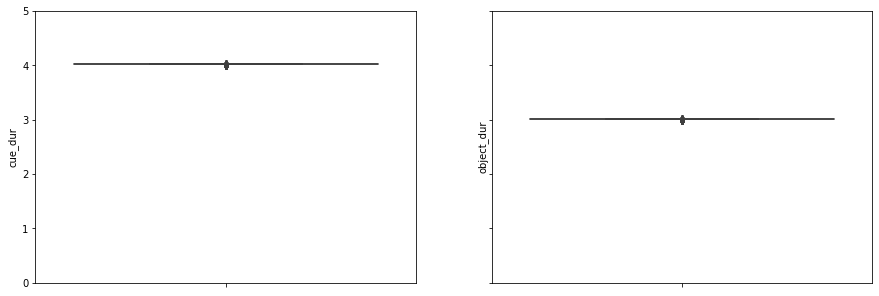

In [47]:
trial_info['object_dur'] = trial_info['beep_time'] - trial_info['object_time']
trial_info['cue_dur'] = trial_info['object_time'] - trial_info['cue_time']

_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0] = sns.boxplot(
    data=trial_info,
    y='cue_dur',
#     hue='subject_id',
#     x='subject_id'
    ax=ax[0]
)
ax[1] = sns.boxplot(
    data=trial_info,
    y='object_dur',
#     hue='subject_id',
#     x='subject_id'
    ax=ax[1]
)
            
ax[0].set(
    ylim=(0, 5)
)

[(0.0, 0.35)]

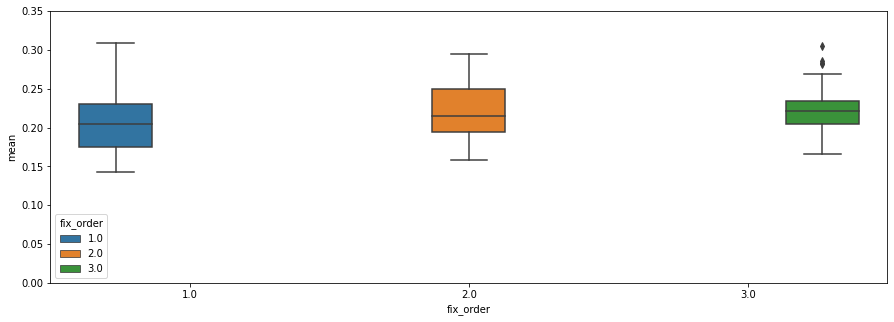

In [48]:
tmp = (
    trial_info
    .groupby(['subject_id', 'fix_order'])
    .fix_duration
    .agg([
        np.mean,
        np.median,
        lambda x: np.mean(x) - 1.95*np.std(x)/np.sqrt(len(x)), #95% ci low
        lambda x: np.mean(x) + 1.95*np.std(x)/np.sqrt(len(x)) #95% ci high 
    ])
    .reset_index()
)

import seaborn as sns

_, ax = plt.subplots(figsize=(15, 5))
ax=sns.boxplot(
    data=tmp,
    y='mean',
    x='fix_order',
    hue='fix_order',
    ax=ax

)
ax.set(
    ylim=(0, 0.35)
)

### reject trials with >50% of outlier fixations

In [49]:
tmp = (
    et_samples_df
    .query('time>=0 and time<=3')
    .groupby(['subject_id', 'block_id', 'trial_id',], as_index=False)
    .agg({'isOutlierFix':'mean', 'isOutlierSac':'mean'})
)
tmp = tmp.query('isOutlierFix > 0.5 or isOutlierSac > 0.5 ')

# reject trials with >>50% of outlier fixations
rejected = list(zip(tmp.subject_id.values, tmp.block_id.values, tmp.trial_id.values))

print(len(rejected))

1173


,index,Unnamed: 0,hmdPos.x,hmdPos.y,hmdPos.z,hmdRotation.x,hmdRotation.y,hmdRotation.z,hmdDirectionForward.x,hmdDirectionForward.y,...,vel_h,vel_v,vel,filt_vel,is_fixation,fix_duration,fix_onset,isOutlierFix,isOutlierSac,fix_order
timestamps,,,,,,,,,,,,,,,,,,,,,


nan
nan
nan


D:\projects\GTI_decoding\code\paper\utils\et_preprocess.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  angular_vel = angular_vel[:,None]
C:\Users\akeshava\.conda\envs\conda_gti_eeg\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\akeshava\.conda\envs\conda_gti_eeg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


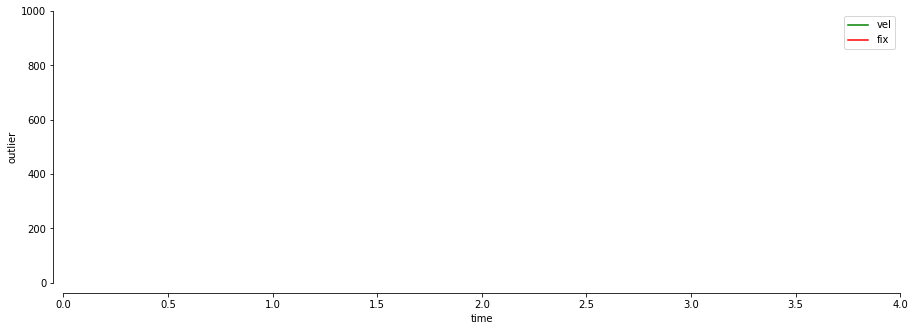

In [50]:

fig, ax = plt.subplots(1,1, figsize=(15, 5), sharey=True)
t = et_samples_df.query('subject_id =="M006" and block_id == "1" and trial_id==14')
display(t)
print(t.query('time>=0 and time<=3').isOutlierFix.mean())
print(t.query('time>=0 and time<=3').isOutlierSac.mean())
#display(t)
thresh = at_mad(t.vel)
print(thresh)
t['fix'] = t.is_fixation * 50
t['outlier'] = t.isOutlierFix * 100
# t['fix_order'] = t.fix_order*50
t.plot(kind='line', x='time', y='vel', color='g', ax=ax)
t.plot(kind='line', x='time', y='fix', color='r', ax=ax)
# t.plot(kind='scatter', x='time', y='fix_order', color='k', ax=ax)
t.plot(kind='scatter', x='time', y='outlier', color='lightblue', ax=ax)
# t.plot(kind='scatter', x='time', y='fix_order', color='blue', ax=ax)


# ax.axhline(thresh, color='grey')
ax.set(ylim=(0,1000));
ax.set(xlim=(0,4));
#ax = t.plot(kind='line', x='time_from_start', y='vel', color='g', ax=ax)

sns.despine(offset=10)

In [51]:
et_samples_df = et_samples_df[~et_samples_df[['subject_id','block_id', 'trial_id']].apply(tuple, 1).isin(rejected)]


# save cleaned data
et_samples_df.reset_index().to_csv(f'{PROCESSED_PATH}/01_ET_samples_cleaned.csv')
et_samples_df.shape

(4305596, 99)

In [52]:
print("Nr. Of Subjects")
display(et_samples_df.subject_id.nunique())

print("Nr. Of Trials")
display(
    et_samples_df
    .groupby(['subject_id', 'block_id'], as_index=False)
    .trial_id
    .nunique()
    .reset_index()
    .trial_id
    .sum()
)

print("Nr. Of Trials/Subjects")
display(
    et_samples_df
    .groupby(['subject_id', 'block_id'], as_index=False)
    .trial_id
    .nunique()
    .groupby('subject_id')
    .trial_id
    .sum()
)

print("Mean Trials/Subjects")
display(
    et_samples_df
    .groupby(['subject_id', 'block_id'], as_index=False)
    .trial_id
    .nunique()
    .groupby('subject_id')
    .trial_id
    .sum()
    .reset_index()
    .trial_id
    .agg(['mean', 'std'])
)


Nr. Of Subjects


25

Nr. Of Trials


5883

Nr. Of Trials/Subjects


subject_id
M006    203
M007    182
M008    234
M009    204
M010    193
M011    272
M012    265
M013    250
M014    278
M015    176
M016    270
M017    231
M018    269
M019    189
M020    252
M021    260
M022    188
M023    253
M024    233
M025    197
M026    249
M027    263
M028    256
M029    251
M030    265
Name: trial_id, dtype: int64

Mean Trials/Subjects


mean    235.320000
std      33.144532
Name: trial_id, dtype: float64

In [53]:
et_samples_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4305596 entries, 232.2678627157584 to 1947127.9601741715
Data columns (total 99 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   index                        int64  
 1   Unnamed: 0                   int64  
 2   hmdPos.x                     float64
 3   hmdPos.y                     float64
 4   hmdPos.z                     float64
 5   hmdRotation.x                float64
 6   hmdRotation.y                float64
 7   hmdRotation.z                float64
 8   hmdDirectionForward.x        float64
 9   hmdDirectionForward.y        float64
 10  hmdDirectionForward.z        float64
 11  controllerPosition.x         float64
 12  controllerPosition.y         float64
 13  controllerPosition.z         float64
 14  controllerRotation.x         float64
 15  controllerRotation.y         float64
 16  controllerRotation.z         float64
 17  CombinedValidityBitMask      float64
 18  eyePositionCo

## Create EEG datasets

In [3]:
TRIGGERS = [
    'BaseLineBeginTimeStamp',
    'BaseLineEndTimeStamp',
    'CueTimeStamp',
    'CueDisappearedTimeStamp',
    'ObjectShownTimeStamp',
    'BeepPlayedTimeStamp',
    'ButtonPressedTimeStamp'
]

TRIAL_INFO = 'TrialInformationInt'

EEG_SIGNAL = 'openvibeSignal'

ET_SIGNAL = 'EyeTrackingGazeHMDFloat'

STIMULUS = ['ToolCueOrientationString', 'ToolCueOrientationInt']

TOOLS = ['daisygrubber', 'fishscaler', 'flowercutter', 'fork', 'paintbrush',
       'paletteknife', 'screwdriver', 'spatula', 'spokewrench', 'trowel',
       'wrench', 'zester']

FAMILIAR = ['fork','trowel','screwdriver','spatula','paintbrush','wrench']

tool_fam_map = {t:('fam' if t in FAMILIAR else 'unfam') for t in TOOLS}

EVENT_MAPPING = {'cue': 1,
                 'cue_end': 2,
                 'object': 3,
                 'go_cue': 4,
                 'trial_end':5 }

montagefile = "./ANT_EEG_channel_mapping.json"



In [4]:
trial_info = pd.read_csv(f'{PROCESSED_PATH}/trial_conditions.csv')

trial_info['raw_data_file'] = (
    DATA_PATH 
    + trial_info['subject_id'].astype(str) + '/' 
    + trial_info['subject_id'].astype(str) + '_' 
    + trial_info['block_id'].astype(str)
    + '.xdf'
)
trial_info

,Unnamed: 0,subject_id,block_id,trial_id,familiarity,task,orientation,tool_name,time,condition,raw_data_file
0,0,M006,1,1.0,unfam,use,right,fishscaler,732,unfam/use/right,./raw_data/M006/M006_1.xdf
1,1,M006,1,2.0,fam,use,right,paintbrush,732,fam/use/right,./raw_data/M006/M006_1.xdf
2,2,M006,1,3.0,fam,use,right,fork,732,fam/use/right,./raw_data/M006/M006_1.xdf
3,3,M006,1,4.0,fam,lift,right,spatula,732,fam/lift/right,./raw_data/M006/M006_1.xdf
4,4,M006,1,5.0,unfam,use,left,fishscaler,732,unfam/use/left,./raw_data/M006/M006_1.xdf
...,...,...,...,...,...,...,...,...,...,...,...
7051,7051,M030,6,44.0,fam,lift,right,fork,732,fam/lift/right,./raw_data/M030/M030_6.xdf
7052,7052,M030,6,45.0,fam,lift,left,screwdriver,731,fam/lift/left,./raw_data/M030/M030_6.xdf
7053,7053,M030,6,46.0,fam,lift,left,spatula,732,fam/lift/left,./raw_data/M030/M030_6.xdf
7054,7054,M030,6,47.0,unfam,use,right,paletteknife,732,unfam/use/right,./raw_data/M030/M030_6.xdf


In [5]:
def find_preprocessed_files(subject_id='', block_id='', save_dir=''):
#     D:\projects\GTI_decoding\code\paper\processed_data\M009\4\eeg\04_cleaned\block_4_eeg.fif
    clean_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/04_cleaned/*_eeg.fif"))
    epoched_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/03_epoched/*_epo.fif"))
    raw_epo_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/05_rawepochs/*_epo.fif"))
    
    if len(clean_fname)==0 or len(epoched_fname) == 0 or len(raw_epo_fname) == 0:
        return ['', '', '']
    
    return [clean_fname[0], epoched_fname[0], raw_epo_fname[0]]

for idx, row in trial_info.iterrows():
    trial_info.loc[idx, ['cleaned_data', 'epoched_data', 'raw_epochs']] = (
        find_preprocessed_files
        (row['subject_id'], 
         row['block_id'], 
         './processed_data/'
        )
    )

In [7]:
empty_trials = trial_info.query('cleaned_data=="" or epoched_data=="" or raw_epochs==""')
data_files = empty_trials.raw_data_file.unique()
print(len(data_files), data_files)

13 ['./raw_data/M013/M013_3.xdf' './raw_data/M013/M013_5.xdf'
 './raw_data/M015/M015_3.xdf' './raw_data/M018/M018_1.xdf'
 './raw_data/M018/M018_3.xdf' './raw_data/M018/M018_4.xdf'
 './raw_data/M020/M020_3.xdf' './raw_data/M022/M022_1.xdf'
 './raw_data/M022/M022_2.xdf' './raw_data/M023/M023_4.xdf'
 './raw_data/M023/M023_5.xdf' './raw_data/M028/M028_1.xdf'
 './raw_data/M028/M028_5.xdf']


In [ ]:
from utils.eeg_preprocess import *
from functools import partial

PROCESSED_PATH = './processed_data/'

# Read EEG Data from xdf
data_files = trial_info.raw_data_file.unique()
with mp.Pool(8) as p:
    retlist = p.map(
                partial(
                    get_eeg_and_preprocess, 
                    trial_info=trial_info,
                    montage=montagefile,
                    save_dir=PROCESSED_PATH,
                ),
                data_files
            )
    
df = pd.DataFrame(retlist)
df.to_csv(f'{PROCESSED_PATH}/EEG_preprocess_status.csv')
display(df)

In [10]:
tmp = pd.DataFrame(retlist)
# tmp.loc[0, 'save_dirs']

# tmp[['events', 'filtered', 'rawepochs', 'cleaned', 'epoched']] = tmp.save_dirs.apply(pd.Series)
df.query('status=="failed"')

,subject_id,block_id,status,save_dirs,error,line_no
0,M010,2,failed,{'events': './processed_data/M010\2\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
1,M013,3,failed,{'events': './processed_data/M013\3\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
2,M013,5,failed,{'events': './processed_data/M013\5\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
3,M015,3,failed,{'events': './processed_data/M015\3\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
4,M018,1,failed,{'events': './processed_data/M018\1\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
5,M018,3,failed,{'events': './processed_data/M018\3\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
6,M018,4,failed,{'events': './processed_data/M018\4\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
7,M020,3,failed,{'events': './processed_data/M020\3\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
8,M022,1,failed,{'events': './processed_data/M022\1\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459
9,M022,2,failed,{'events': './processed_data/M022\2\eeg/01_eve...,index 0 is out of bounds for axis 0 with size 0,459


In [12]:
"""
Get the EEG data from xdf file. 
The xdf contains both the EEG and the eye tracking data.
Read xdf and extract just the EEG
"""
subject_id = "M022"
block_id = 1
fname=f'./raw_data/{subject_id}/{subject_id}_{block_id}.xdf'
DATA = './raw_data/M010'
DATA_FILE = "M006_3.xdf"

# Read Data from xdf
data, header = pyxdf.load_xdf(fname)

[
    print(
        f"Stream ID:{idx} \n", 
        f"Stream Name: {stream['info']['name']}\n", 
        f"Stream Fields: {stream['info']['desc'][0].keys()}\n",
        f"Stream Time: {stream['time_stamps'].shape}\n",
#         f"Stream First Time: {stream['time_stamps'][0]}\n\n"
    ) 
    for idx, stream in enumerate(data)
    
]

stream = get_streams(data)

stream

Stream ID:0 
 Stream Name: ['openvibeMarkers']
 Stream Fields: dict_keys(['channels'])
 Stream Time: (0,)

Stream ID:1 
 Stream Name: ['openvibeSignal']
 Stream Fields: dict_keys(['channels'])
 Stream Time: (1634272,)

Stream ID:2 
 Stream Name: ['EyetrackingTimeStamp']
 Stream Fields: dict_keys(['CurrentFrameTimeStamp'])
 Stream Time: (71192,)

Stream ID:3 
 Stream Name: ['ValidationResults']
 Stream Fields: dict_keys(['xError', 'yError', 'zError'])
 Stream Time: (7,)

Stream ID:4 
 Stream Name: ['ObjectShownTimeStamp']
 Stream Fields: dict_keys(['ObjectShownTimeStamp'])
 Stream Time: (48,)

Stream ID:5 
 Stream Name: ['TrialStopMeasurementTimeStamp']
 Stream Fields: dict_keys(['TrialStopMeasurementTimeStamp'])
 Stream Time: (0,)

Stream ID:6 
 Stream Name: ['CueTimeStamp']
 Stream Fields: dict_keys(['CueTimeStamp'])
 Stream Time: (48,)

Stream ID:7 
 Stream Name: ['BaseLineBeginTimeStamp']
 Stream Fields: dict_keys(['BaseLineBeginTimeStamp'])
 Stream Time: (2,)

Stream ID:8 
 Stream 

{'eeg': 1,
 'ObjectShownTimeStamp': 4,
 'CueTimeStamp': 6,
 'BaseLineBeginTimeStamp': 7,
 'CueDisappearedTimeStamp': 10,
 'BaseLineEndTimeStamp': 11,
 'TrialInformationInt': 12,
 'et': 13,
 'ButtonPressedTimeStamp': 14,
 'BeepPlayedTimeStamp': 15}

In [13]:
data[stream['BaseLineBeginTimeStamp']]["time_stamps"][1] - data[stream['eeg']]["time_stamps"][0]

798.0633430702146

In [14]:
begin = int(np.searchsorted(
            data[stream['eeg']]["time_stamps"],
            data[stream['BaseLineBeginTimeStamp']]["time_stamps"][0]
))

end = int(np.searchsorted(
            data[stream['eeg']]["time_stamps"],
            data[stream['BaseLineEndTimeStamp']]["time_stamps"][0]
))

start_time = data[stream['eeg']]["time_stamps"][0]
eeg_time = data[stream['eeg']]["time_stamps"] - start_time  # get eeg time points

begin_time = data[stream['eeg']]["time_stamps"][begin] - start_time
end_time = data[stream['eeg']]["time_stamps"][end] - start_time

print(begin_time, end_time)

sr = data[stream['eeg']]['info']['effective_srate']  # sampling rate of eeg

n_ch = int(data[stream['eeg']]['info']['channel_count'][0])  # no. of eeg channels

ch_typ = ['eeg'] * n_ch  # set channel type for mne

ch_names = get_channel_names(
    data[stream['eeg']]['info']['desc'][0]['channels'][0]['channel'],
    n_ch,
    montagefile
)
# create mne info
info = mne.create_info(ch_names, ch_types=ch_typ, sfreq=sr)

# # mne data array should be in (nChannel,nSamples) whereas xdf stores in (nSamples,nChannel)
eeg = mne.io.RawArray(np.transpose(data[stream['eeg']]["time_series"]), info)

# # drop auxiliaries and not needed channels
eeg.drop_channels(['BIP65', 'BIP66', 'BIP67', 'BIP68', 'AUX69', 'AUX70', 'AUX71', 'AUX72'])

# set the montage
eeg.set_montage('standard_1020')

# reject the first 20 secs to get rid of voltage swings at the start
# resample to 256Hz
# Note: the raw and the event are resampled simultaneously so that they stay more or less in synch.
eeg.crop(tmin=begin_time, tmax=end_time)

eeg.__len__()

99.65429680468515 104.66308586369269
Creating RawArray with float64 data, n_channels=72, n_times=1634272
    Range : 0 ... 1634271 =      0.000 ...  1595.968 secs
Ready.


5130

In [10]:
print(os.getenv("HOME"))

C:\Users\akeshava


In [9]:
trial_info

,Unnamed: 0,subject_id,block_id,trial_id,familiarity,task,orientation,tool_name,time,condition,raw_data_file,cleaned_data,epoched_data,raw_epochs
0,0,M006,1,1.0,unfam,use,right,fishscaler,732,unfam/use/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
1,1,M006,1,2.0,fam,use,right,paintbrush,732,fam/use/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
2,2,M006,1,3.0,fam,use,right,fork,732,fam/use/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
3,3,M006,1,4.0,fam,lift,right,spatula,732,fam/lift/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
4,4,M006,1,5.0,unfam,use,left,fishscaler,732,unfam/use/left,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,7051,M030,6,44.0,fam,lift,right,fork,732,fam/lift/right,./raw_data/M030/M030_6.xdf,./processed_data/M030\6\eeg/04_cleaned\block_6...,./processed_data/M030\6\eeg/03_epoched\block_6...,./processed_data/M030\6\eeg/05_rawepochs\block...
7052,7052,M030,6,45.0,fam,lift,left,screwdriver,731,fam/lift/left,./raw_data/M030/M030_6.xdf,./processed_data/M030\6\eeg/04_cleaned\block_6...,./processed_data/M030\6\eeg/03_epoched\block_6...,./processed_data/M030\6\eeg/05_rawepochs\block...
7053,7053,M030,6,46.0,fam,lift,left,spatula,732,fam/lift/left,./raw_data/M030/M030_6.xdf,./processed_data/M030\6\eeg/04_cleaned\block_6...,./processed_data/M030\6\eeg/03_epoched\block_6...,./processed_data/M030\6\eeg/05_rawepochs\block...
7054,7054,M030,6,47.0,unfam,use,right,paletteknife,732,unfam/use/right,./raw_data/M030/M030_6.xdf,./processed_data/M030\6\eeg/04_cleaned\block_6...,./processed_data/M030\6\eeg/03_epoched\block_6...,./processed_data/M030\6\eeg/05_rawepochs\block...


In [ ]:
channel_info = data[eeg_stream]['info']['desc'][0]['channels'][0]['channel']
#print(channel_info)
channels = [ch['label'] for ch in channel_info] ## returns list of lists

channels = [ch[0] for ch in channels] ## make into one list

n_channels = len(channels)

In [ ]:
info = mne.create_info(ch_names=channels, sfreq=srate)

raw = mne.io.RawArray(data[eeg_stream]['time_series'].transpose(), info)
# raw.plot(scalings=dict(eeg=100e-6))

In [ ]:
%matplotlib qt
raw.plot(show_scrollbars=True, show_scalebars=True, start=0, duration=10, scalings=dict(eeg=100e-3))